# ZUM Project 1 - Team #4 (Ruba, Yulia) - Brain Tumor Detection: Solving a Classification Problem

## Project Description and Objective
There is a set of MRI scans with human brain. Some of the images show the brain with a tumor, some of them - not. The project objective is to construct a machine learning algorithm in order to detect which MRI images shows the brain with / without a tumor.

## Project Methodology

- 1) Load and understand the data.
- 2) Label the taget variable.
- 3) Split the data into train, validation and test subsamples for effective learning.
- 4) Construct the model. As a benchmark for image recongnition and classification problem solving a convolutional neural network was chosen.
- 5) Training the CNN model, using train sample, refering in the layer to validation data.
- 6) Visulazing and analyzing the training results, accuracy score and loss function value.
- 7) Improving the CNN model in order to increase the accuracy score and minimize a loss function.
- 8) Evaluating the final training results.
- 9) Testing the final CNN model: making predictions, building classification report, confuction matrix.


## Data
The dataset is taken from the [open-source](https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection).

## Theory

https://colab.research.google.com/drive/1V_V0vZgUp_2GSrvbBTjdil0oYrQ2i3nl#scrollTo=TVcIID4LlxZQ

How exactly will this learning take place, given the Layer and Operation classes just defined? Recalling how the model from the last chapter worked, we’ll implement the
following:
- 1. The neural network should take X and pass it successively forward through each
Layer (which is really a convenient wrapper around feeding it through many
Operations), at which point the result will represent the prediction.
- 2. Next, prediction should be compared with the value y to calculate the loss and
generate the “loss gradient,” which is the partial derivative of the loss with respect
to each element in the last layer in the network (namely, the one that generated
the prediction).
- 3. Finally, we’ll send this loss gradient successively backward through each layer,
along the way computing the “parameter gradients”—the partial derivative of the
loss with respect to each of the parameters—and storing them in the corresponding
Operations.

In [78]:
import os
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('dark_background')
import seaborn as sns

from sklearn.utils import shuffle
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras import layers
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import warnings
warnings.filterwarnings('ignore')

# 1 Data Preprocessing

## 1.1 One Hot Encoding the Target Classes

In [79]:
encoder = OneHotEncoder()
encoder.fit([[0],[1]])

# 0 no tumor
# 1 yes tumor

OneHotEncoder()

In [80]:
encoder.categories_

[array([0, 1])]

## 1.2 Creating lists for storing encoded samples (X, y)

- Processing images with a tumor

In [81]:
# creating lists to store the data with tumor
X = []
paths = []
y = []

for r, d, f in os.walk(r'/Users/yuliabezginova/PycharmProjects/00_files-for_NLP/Brain MRI Images for Brain Tumor Detection/brain_tumor_dataset/yes/'):
    for file in f:
        if '.jpg' in file:
            paths.append(os.path.join(r, file))
                         
# updating result list for the images with a tumor
for path in paths:
    img = Image.open(path)
    img = img.resize((200, 200)) 
    img = np.array(img)
    if(img.shape == (200, 200, 3)):
        X.append(np.array(img))
        y.append(encoder.transform([[0]]).toarray())                         
                         

- Processing images without a tumor

In [82]:
# creating lists to store the data
paths = []

for r, d, f in os.walk(r'/Users/yuliabezginova/PycharmProjects/00_files-for_NLP/Brain MRI Images for Brain Tumor Detection/brain_tumor_dataset/no/'):
    for file in f:
        if '.jpg' in file:
            paths.append(os.path.join(r, file))
                         
# updating result list for the images with a tumor
for path in paths:
    img = Image.open(path)
    img = img.resize((200, 200))
    img = np.array(img)
    if(img.shape == (200, 200, 3)):
        X.append(np.array(img))
        y.append(encoder.transform([[1]]).toarray())                         
                         

In [83]:
# coverting the data into array format
X = np.array(X)
X.shape

(139, 200, 200, 3)

In [84]:
y = np.array(y)
y = y.reshape(len(X), 2)

### Checking for target disbalance

In [85]:
y_df = pd.DataFrame(y)

In [86]:
y_df.value_counts()

0    1  
1.0  0.0    70
0.0  1.0    69
dtype: int64

## 1.3 Data Normalization (scaling)

In [87]:
norm_data = X / 255.0
norm_data = np.expand_dims(norm_data, axis=3)
norm_data.shape, norm_data[0]

((139, 200, 200, 1, 3),
 array([[[[0.00392157, 0.00392157, 0.00392157]],
 
         [[0.00392157, 0.00392157, 0.00392157]],
 
         [[0.00392157, 0.00392157, 0.00392157]],
 
         ...,
 
         [[0.00392157, 0.00392157, 0.00392157]],
 
         [[0.00392157, 0.00392157, 0.00392157]],
 
         [[0.00392157, 0.00392157, 0.00392157]]],
 
 
        [[[0.00392157, 0.00392157, 0.00392157]],
 
         [[0.00392157, 0.00392157, 0.00392157]],
 
         [[0.00392157, 0.00392157, 0.00392157]],
 
         ...,
 
         [[0.00392157, 0.00392157, 0.00392157]],
 
         [[0.00392157, 0.00392157, 0.00392157]],
 
         [[0.00392157, 0.00392157, 0.00392157]]],
 
 
        [[[0.00392157, 0.00392157, 0.00392157]],
 
         [[0.        , 0.        , 0.        ]],
 
         [[0.        , 0.        , 0.        ]],
 
         ...,
 
         [[0.00392157, 0.00392157, 0.00392157]],
 
         [[0.00392157, 0.00392157, 0.00392157]],
 
         [[0.00392157, 0.00392157, 0.00392157]]],
 
 
 

## 1.4 Data Split

In [88]:
# X_train, X_test, y_train, y_test = train_test_split(X, 
#                                                     y, 
#                                                     random_state=5, 
#                                                     test_size=0.2,
#                                                    shuffle=True)


X_train, X_other, y_train, y_other = train_test_split(X, y, 
                                                      test_size=0.30, 
                                                      random_state=5)


X_valid, X_test, y_valid, y_test = train_test_split(X_other, 
                                                    y_other,
                                              test_size=0.66, 
                                              random_state=5)

In [89]:
print('Train features sample size:', X_train.shape[0])
print('Train target sample size:', y_train.shape[0])
print()
print('Validation features sample size:', X_valid.shape[0])
print('Validation target sample size:', y_valid.shape[0])
print()
print('Test features sample size:', X_test.shape[0])
print('Test target sample size:', y_test.shape[0])
print()
print('Train features sample size, %:', round(len(X_train) / len(X) * 100), '%')
print('Valid features sample size, %:', round(len(X_valid) / len(X) * 100), '%')
print('Test features sample size, %:', round(len(X_test) / len(X) * 100), '%')
print()
print('Train target sample size, %:', round(len(y_train) / len(y) * 100), '%')
print('Valid target sample size, %:', round(len(y_valid) / len(y) * 100), '%')
print('Test target sample size, %:', round(len(y_test) / len(y) * 100), '%')

Train features sample size: 97
Train target sample size: 97

Validation features sample size: 14
Validation target sample size: 14

Test features sample size: 28
Test target sample size: 28

Train features sample size, %: 70 %
Valid features sample size, %: 10 %
Test features sample size, %: 20 %

Train target sample size, %: 70 %
Valid target sample size, %: 10 %
Test target sample size, %: 20 %


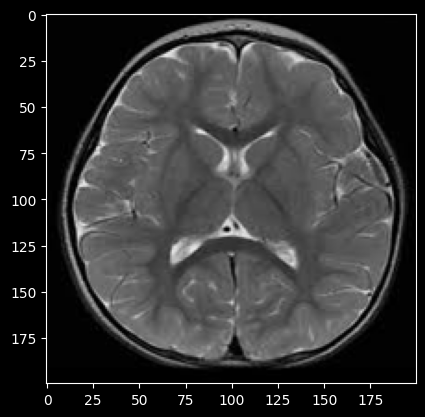

In [90]:
plt.imshow(X[132], cmap='gray');

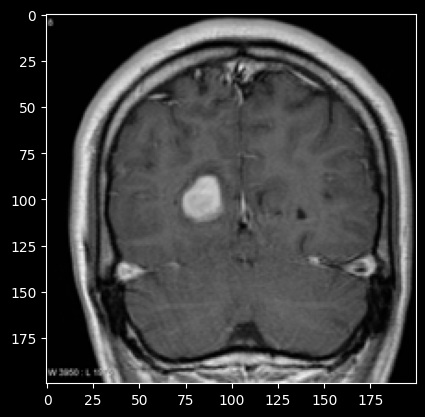

In [91]:
plt.imshow(X[13], cmap='gray');

### ***Conclusion***: We have normalized, augmented and split the initial dataset into train (70%), validation (10%) and test (20%) samples, and thus ready to train the ML model.

The subsamples are the following:
- X_train 70%
- y_train 70%

- X_valid 10%
- y_valid 10%

- X_test 20%
- y_test 20%

## 1.6 Tackling the disbalance

In [92]:
y_train_df = pd.DataFrame(y_train)

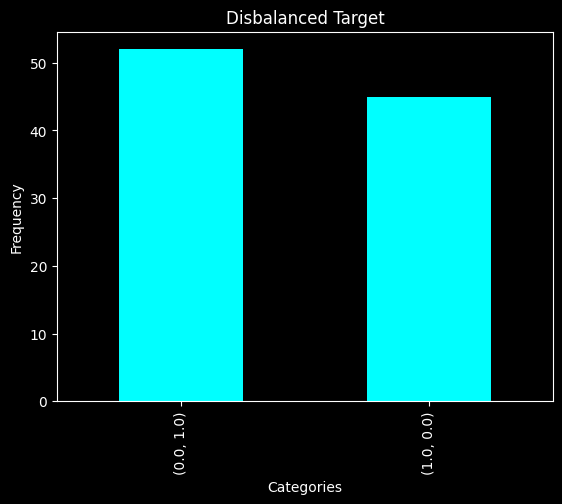

In [93]:
y_train_df.value_counts().plot(kind='bar', color=['cyan'])

plt.title('Disbalanced Target')
plt.xlabel('Categories')
plt.ylabel('Frequency')
plt.show();

In [94]:
y_test_df = pd.DataFrame(y_test)

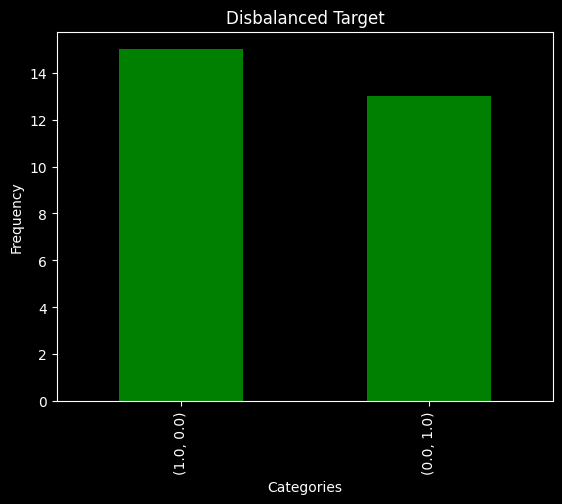

In [95]:
y_test_df.value_counts().plot(kind='bar', color=['green'])

plt.title('Disbalanced Target')
plt.xlabel('Categories')
plt.ylabel('Frequency')
plt.show();

### ***Conclusion***: As long as the test data is quite well balanced, we keep it as is.

# 2 Constructing a convolutional neural network

#### Convolution Neural Network (CNN) is widely used for analysing visual images. This network is used in image classification and detection, image segmentation. In CNN we have 
- Convolution + relu 
- Maxpooling layer
- Convolution + relu
- Maxpooling layer 
- Flattern
- Fully connected layer


BatchNormalization is a techniguq for training very deep neural networks that standardizes the inputs to a layer for each mini-batch. This has the effect of stabilizing the learning process and dramatically reducing the number of training epochs required to train deep networkds.

**Padding** is a term relevant to convolutional neural networks as it refers to the amount of pixels added to an image when it is being processed by the kernel of a CNN. For example, if the padding in a CNN is set to zero, then every pixel value that is added will be of value zero.
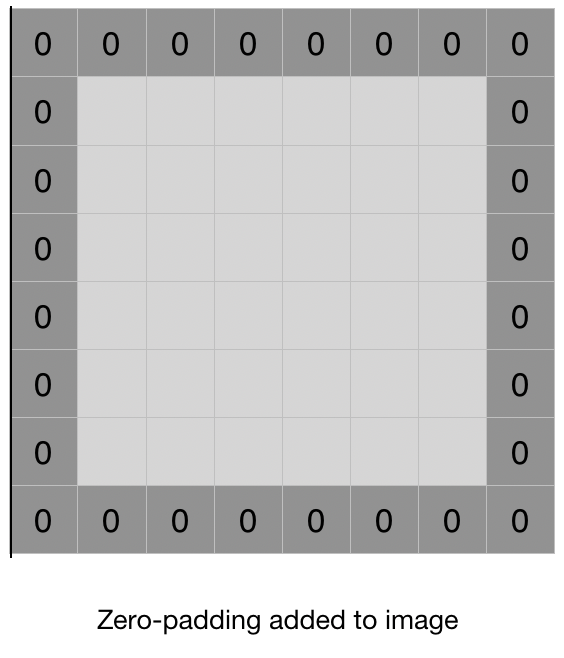

If zero padding = 1, there will be one pixel thick around the original image with pixel value = 0.

### 2.1 Initiating the model of CNN

In [99]:
model = Sequential()
import warnings
warnings.filterwarnings('ignore')

In [100]:
model.add(Conv2D(32, kernel_size=(2, 2), activation ='relu', input_shape=(200,200, 3), padding='Same'))

model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, kernel_size = (2,2), activation ='relu',padding='Same'))

model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(200, activation='relu'))
model.add(Dense(2, activation='softmax'))

model.compile(loss = "categorical_crossentropy", 
              optimizer='Adamax',
             metrics=["accuracy"])


model.summary()


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_11 (Conv2D)          (None, 200, 200, 32)      416       
                                                                 
 batch_normalization_10 (Bat  (None, 200, 200, 32)     128       
 chNormalization)                                                
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 100, 100, 32)     0         
 g2D)                                                            
                                                                 
 dropout_10 (Dropout)        (None, 100, 100, 32)      0         
                                                                 
 conv2d_12 (Conv2D)          (None, 100, 100, 64)      8256      
                                                                 
 batch_normalization_11 (Bat  (None, 100, 100, 64)    

### 2.2 Training the model of CNN

In [101]:
history = model.fit(X_train, y_train, epochs=50, 
                    batch_size=32,
                    verbose=1,
                    validation_data=(X_valid, y_valid),
          shuffle=False)

Epoch 1/50
4/4 [==============================] - 13s 2s/step - loss: 113.9177 - accuracy: 0.4536 - val_loss: 13.1720 - val_accuracy: 0.7143
Epoch 2/50
4/4 [==============================] - 12s 3s/step - loss: 2.4750 - accuracy: 0.6907 - val_loss: 8.8051 - val_accuracy: 0.7143
Epoch 3/50
4/4 [==============================] - 7s 2s/step - loss: 1.1803 - accuracy: 0.7835 - val_loss: 3.3970 - val_accuracy: 0.7143
Epoch 4/50
4/4 [==============================] - 7s 2s/step - loss: 0.9576 - accuracy: 0.7938 - val_loss: 1.8114 - val_accuracy: 0.7857
Epoch 5/50
4/4 [==============================] - 7s 2s/step - loss: 0.8303 - accuracy: 0.8144 - val_loss: 1.3714 - val_accuracy: 0.7857
Epoch 6/50
4/4 [==============================] - 7s 2s/step - loss: 0.4306 - accuracy: 0.8454 - val_loss: 1.5198 - val_accuracy: 0.7143
Epoch 7/50
4/4 [==============================] - 7s 2s/step - loss: 0.3337 - accuracy: 0.8866 - val_loss: 1.5146 - val_accuracy: 0.7143
Epoch 8/50
4/4 [====================

In [102]:
# deep_neural_network = NeuralNetwork(
#     layers=[Dense(neurons=13,
#                 activation=Sigmoid()),
#             Dense(neurons=13,
#                 activation=Sigmoid()),
#             Dense(neurons=1,
#                 activation=LinearAct())],
#     loss=MeanSquaredError(),
#     learning_rate=0.01
# )

### 2.3 Plotting validation losses

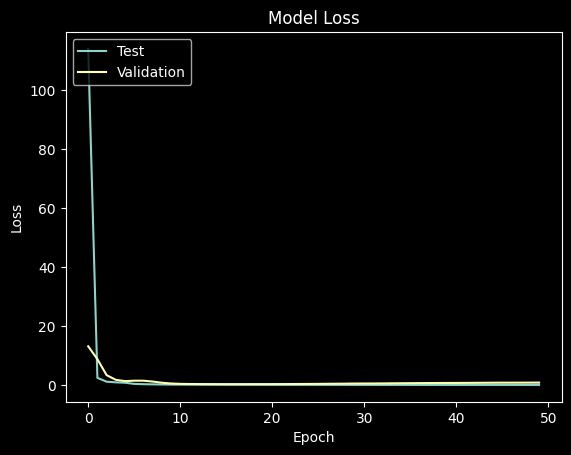

In [103]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Test', 'Validation'], loc='upper left')
plt.show()

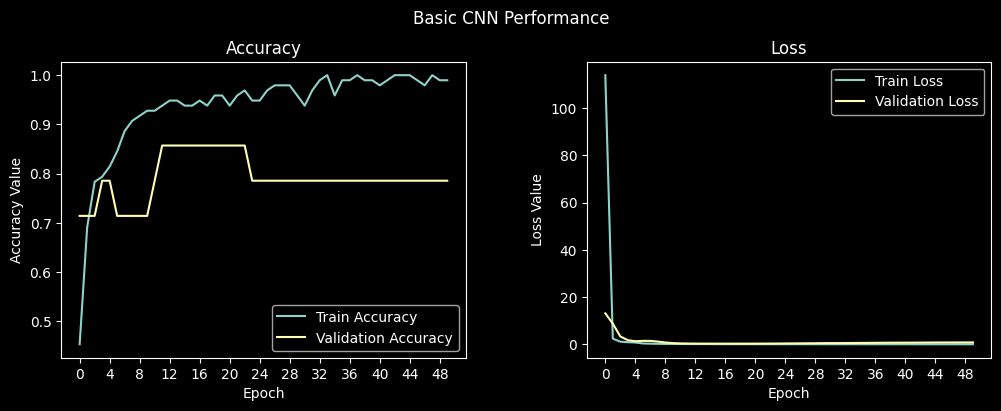

In [104]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Basic CNN Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(0,50))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')

ax1.set_xticks(np.arange(0, 50, 4))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 50, 4))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

### 2.4 Testing the CNN model before reducing the overfitting

In [105]:
# pred_valid = model.predict(X_valid, batch_size=32)
y_pred_valid = np.argmax(model.predict(X_valid, batch_size=32), axis=1)

actual_valid = np.argmax(y_valid, axis=1)
print(actual_valid)

1/1 [==============================] - 1s 737ms/step
[0 0 0 0 0 0 0 1 1 0 1 0 0 1]


### Accuracy of the constructed model:

In [106]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=1)
loss_v, accuracy_v = model.evaluate(X_valid, y_valid, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (accuracy_v, loss_v))
print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))
# model.save("model.h5")

1/1 [==============================] - 1s 591ms/step - loss: 0.8672 - accuracy: 0.7857
Validation: accuracy = 0.785714  ;  loss_v = 0.867214
Test: accuracy = 0.785714  ;  loss = 1.146020


### ***Conclusion***: As a result of training and evaluating the convolutional neural network, the accuracy score is 78.5%, while ***loss*** is 1.15. The scores is reasonably good, however on the graphs we can see that the accuracy on the training and validation are far from each other, meaning they differ a lot. Hence, we are now going to increase the overall model production.

## 3 Tackling the overfitting

### 3.1 Data Augmentation

https://www.tensorflow.org/tutorials/images/classification

#### What is data augmentation?

Data augmentation is a set of techniques to artificially increase the amount of data by generating new data points from existing data. This includes making small changes to data or using deep learning models to generate new data points before splitting the dataset into train / test.

#### 3D array X can be reshaped into a 2D array X_adj using .reshape(-1)

In [107]:
data_augmentation = Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(200,
                                  200,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

import warnings
warnings.filterwarnings('ignore')

In [108]:
model = Sequential([data_augmentation])
import warnings
warnings.filterwarnings('ignore')

model.add(Conv2D(32, kernel_size=(2, 2), activation ='relu', input_shape=(200,200, 3), padding='Same'))

model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, kernel_size = (2,2), activation ='relu',padding='Same'))

model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(200, activation='relu'))
model.add(Dense(2, activation='softmax'))

model.compile(loss = "categorical_crossentropy", 
              optimizer='Adamax',
             metrics=["accuracy"])

In [109]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_8 (Sequential)   (None, 200, 200, 3)       0         
                                                                 
 conv2d_13 (Conv2D)          (None, 200, 200, 32)      416       
                                                                 
 batch_normalization_12 (Bat  (None, 200, 200, 32)     128       
 chNormalization)                                                
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 100, 100, 32)     0         
 g2D)                                                            
                                                                 
 dropout_12 (Dropout)        (None, 100, 100, 32)      0         
                                                                 
 conv2d_14 (Conv2D)          (None, 100, 100, 64)     

In [110]:
history = model.fit(X_train, y_train, epochs=70, 
                    batch_size=32,
                    verbose=1,
                    validation_data=(X_valid, y_valid),
          shuffle=False)

Epoch 1/70
4/4 [==============================] - 35s 5s/step - loss: 155.9594 - accuracy: 0.5258 - val_loss: 16.4891 - val_accuracy: 0.7143
Epoch 2/70
4/4 [==============================] - 15s 3s/step - loss: 6.7161 - accuracy: 0.5876 - val_loss: 6.8218 - val_accuracy: 0.7143
Epoch 3/70
4/4 [==============================] - 10s 2s/step - loss: 1.9076 - accuracy: 0.6495 - val_loss: 2.8310 - val_accuracy: 0.7143
Epoch 4/70
4/4 [==============================] - 8s 2s/step - loss: 1.2060 - accuracy: 0.5670 - val_loss: 2.0303 - val_accuracy: 0.7143
Epoch 5/70
4/4 [==============================] - 8s 2s/step - loss: 0.7638 - accuracy: 0.5361 - val_loss: 1.6935 - val_accuracy: 0.7143
Epoch 6/70
4/4 [==============================] - 7s 2s/step - loss: 0.6672 - accuracy: 0.5567 - val_loss: 1.3216 - val_accuracy: 0.7143
Epoch 7/70
4/4 [==============================] - 8s 2s/step - loss: 0.6912 - accuracy: 0.5464 - val_loss: 1.0780 - val_accuracy: 0.7143
Epoch 8/70
4/4 [===================

4/4 [==============================] - 9s 2s/step - loss: 0.4477 - accuracy: 0.7113 - val_loss: 1.8281 - val_accuracy: 0.7857
Epoch 43/70
4/4 [==============================] - 13s 3s/step - loss: 0.4466 - accuracy: 0.7216 - val_loss: 1.8851 - val_accuracy: 0.7857
Epoch 44/70
4/4 [==============================] - 10s 2s/step - loss: 0.4628 - accuracy: 0.7216 - val_loss: 1.9330 - val_accuracy: 0.7857
Epoch 45/70
4/4 [==============================] - 9s 2s/step - loss: 0.4558 - accuracy: 0.7526 - val_loss: 1.9703 - val_accuracy: 0.7857
Epoch 46/70
4/4 [==============================] - 9s 2s/step - loss: 0.4525 - accuracy: 0.7526 - val_loss: 2.0384 - val_accuracy: 0.7857
Epoch 47/70
4/4 [==============================] - 9s 2s/step - loss: 0.3985 - accuracy: 0.7732 - val_loss: 2.1081 - val_accuracy: 0.7857
Epoch 48/70
4/4 [==============================] - 10s 2s/step - loss: 0.4697 - accuracy: 0.7423 - val_loss: 2.1416 - val_accuracy: 0.7143
Epoch 49/70
4/4 [==========================

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


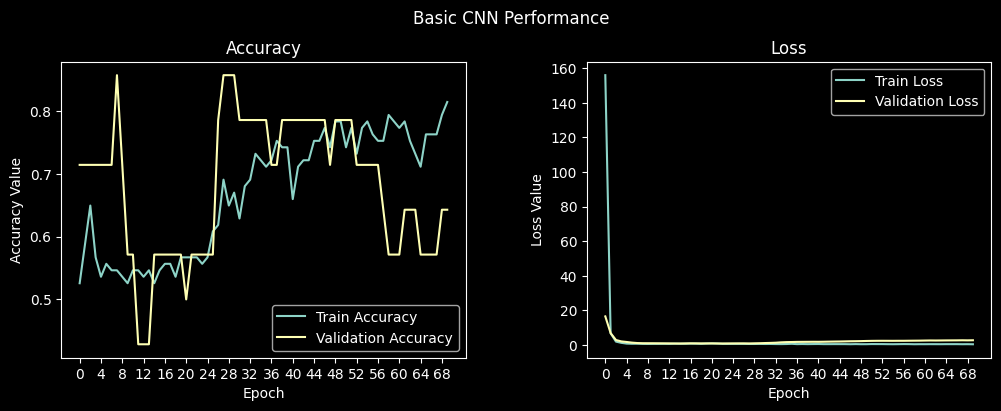

In [119]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Basic CNN Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(0, 70))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='upper right')

ax1.set_xticks(np.arange(0, 70, 4))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 70, 4))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

### Accuracy score of the improved model:

In [120]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=1)
loss_v, accuracy_v = model.evaluate(X_valid, y_valid, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (accuracy_v, loss_v))
print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))
# model.save("model.h5")

1/1 [==============================] - 0s 226ms/step - loss: 2.6940 - accuracy: 0.6429
Validation: accuracy = 0.642857  ;  loss_v = 2.694034
Test: accuracy = 0.750000  ;  loss = 0.818077


### ***Conclusion***: The model was improved by ***data augmentation*** in order to improve the CNN model perfomance. After improving the model, we can see that accuracy has become lower 75.0%, which is worse than before. However, the loss function is minimized much better - the loss_value is 81.8 (instead of 1.8), which means that balance between bias and variance errors is achieved.

## 4 Testing the model

### 4.1 Making predictions

In [121]:
%%time
prediction = model.predict(X_test, batch_size=32)
y_pred = np.argmax(prediction, axis=1)

actual = np.argmax(y_test, axis=1)
print(actual)

1/1 [==============================] - 1s 933ms/step
[0 1 0 0 1 1 1 0 0 1 1 1 0 0 0 0 1 0 0 0 0 1 1 1 0 0 1 1]
CPU times: user 898 ms, sys: 459 ms, total: 1.36 s
Wall time: 1.02 s


### 4.2 Classification Report

Precision - the precision tells us what percentage of the prediction was correct. 
TP = True positive
FP = False positive
precision = TP/TP+FP

Recall - sensitivity or hit rate tell us the fraction of correctly identified positive prediction.
recall = TP/TP+FN

F1-score - measures precision and recall at the same time by finding the harmonic mean of the two values.
F1 Score = 2*(Recall * Precision) / (Recall + Precision)

Accuracy - The accuracy measures the accuracy of all predictions (positive and negative).
Accuracy = TP+TN/TP+TN+FP+FN

In [122]:
print('Classification Report')
target_names = ['no', 'yes']
print(classification_report(y_pred, actual, target_names = target_names))

Classification Report
              precision    recall  f1-score   support

          no       0.80      0.75      0.77        16
         yes       0.69      0.75      0.72        12

    accuracy                           0.75        28
   macro avg       0.75      0.75      0.75        28
weighted avg       0.75      0.75      0.75        28



### 4.3 Confusion Matrix

#### Let's find the overall accuracy of the model using 
Accuracy = TP+TN/TP+TN+FP+FN

*   cm[0][0] = TP
*   cm[1][1] = TN
*   cm[0][1] = FP
*   cm[1][0] = FN

In [123]:
# print(classification_report(actual, prediction, target_names=label_binarizer.classes_))
print('Confusion Matrix')
print(confusion_matrix(y_pred, actual))

Confusion Matrix
[[12  4]
 [ 3  9]]


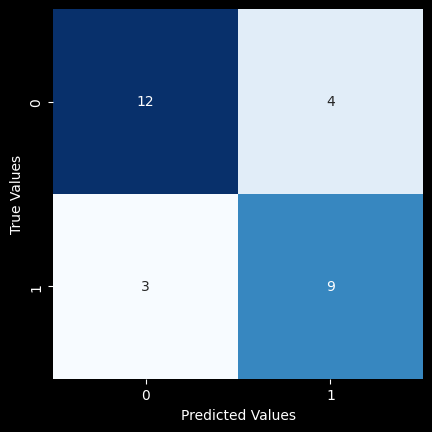

In [124]:
cm=confusion_matrix(y_pred, actual)
sns.heatmap(cm, square=True, annot=True, cbar=False, cmap=plt.cm.Blues)
plt.xlabel('Predicted Values')
plt.ylabel('True Values');

In [125]:
cm = confusion_matrix(y_pred, actual)
total = sum(sum(cm))
accuracy = (cm[0, 0] + cm[1, 1]) / total
print("Accuracy: {:.4f}".format(accuracy));

Accuracy: 0.7500


#### Confusion matrix is used to evaluate the accuracy of a machine learning model that tries to predict classes(eg. classification)

*   Top left quadrant - True Positive
* Bottom right quadrant - True Negative
*   Top right quadrant - False Positive
*   Bottom left quadrant - False Negative

[Text(0, 0.5, 'There is a tumor'), Text(0, 1.5, 'There is no tumor')]

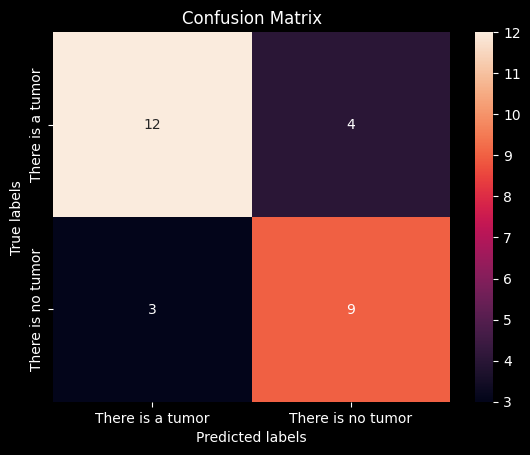

In [126]:
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['There is a tumor', 'There is no tumor']); ax.yaxis.set_ticklabels(['There is a tumor', 'There is no tumor'])

### ***Final Conclusions***: As a result the project, the convolutional neural network was constructed for MRI images recognition. The data was preprocessed, normalized, and split into three subsamples - train, validation and test ones. 

### After the 1st run of training the CNN model, the accuracy score was achieved 73% on the validation sample, while the loss function value was 7.9. 

### As an optimization ML algorithm, data augmentation was applied. After improving the CNN model, the performance became better: accuracy remained almost the same 75.0%, while the loss function was much more minimized from 1.01 to 0.87. The final version of CNN model was tested for real images from the dataset.